In [348]:
import numpy as np
import os
import random
import glob
import pandas as pd
import time
import sklearn as sk
import matplotlib.pyplot as plt
import importlib
from common import common
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from functools import partial
from joblib import Parallel, delayed

In [349]:
# Reload common module
importlib.reload(common)

<module 'common.common' from '/Users/suyeetan/Downloads/CS5344_Project/work/common/common.py'>

In [350]:
# Shared variables
OUTPUT_FOLDER = 'csv_files'
FEATURE_FOLDER = 'features'
TEST_COUNT = 35000

In [351]:
%run datasets/covertype.ipynb
# %run datasets/kdd.ipynb
# %run datasets/cicids.ipynb
# %run datasets/unsw.ipynb
# %run datasets/thyroid.ipynb

In [352]:
# Should already be one hot encoded and label encoded
all_df, main_labels, config = get_processed_covtype_df()
# all_df, main_labels, config = get_processed_kdd_df()
# all_df, main_labels, config = get_processed_cicids_df()
# all_df, main_labels, config = get_processed_unsw_df()
# all_df, main_labels, config = get_processed_thyroid_df()
TARGET_COLUMN = config['TARGET_COLUMN']
NORMAL_TARGET = config['NORMAL_TARGET']
TARGET_DICT = config['TARGET_DICT']
INV_TARGET_DICT = config['INV_TARGET_DICT']
NUMERICAL_COLUMNS = config['NUMERICAL_COLUMNS']
CATEGORICAL_COLUMNS = config['CATEGORICAL_COLUMNS']
ORDINAL_COLUMNS = config['ORDINAL_COLUMNS']
all_df.head()

Normal class:  0    2
Name: Cover_Type, dtype: int32


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [353]:
all_df.shape

(581012, 55)

In [354]:
# Create a folder to save the CSVs
common.remove_files_from_directory(OUTPUT_FOLDER)
common.remove_files_from_directory(FEATURE_FOLDER)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(FEATURE_FOLDER, exist_ok=True)

All files in csv_files have been removed.
All files in features have been removed.


In [355]:
# Save all data as csv
all_df.to_csv('all_data.csv' ,index = False)

In [356]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and test sets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(464809, 54) (116203, 54) (464809,) (116203,)


In [357]:
# Concatenate X_train and y_train along the columns (axis=1)
X_y_train_df = pd.concat([X_train_df, y_train_df], axis=1)
X_y_train_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
519924,3289.0,22.0,19.0,240.0,93.0,1708.0,205.0,196.0,122.0,2598.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
318451,2963.0,21.0,18.0,134.0,27.0,1243.0,206.0,200.0,127.0,1140.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
22325,3037.0,185.0,9.0,127.0,10.0,6462.0,222.0,246.0,158.0,3037.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
449376,3113.0,203.0,13.0,190.0,22.0,2125.0,213.0,251.0,171.0,730.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
482753,3128.0,346.0,9.0,120.0,36.0,552.0,203.0,226.0,161.0,924.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [358]:
# Fit and transform the numeric columns
scaler, X_train_scaled_df = common.standardise(X_train_df, NUMERICAL_COLUMNS)
# print('X_train_scaled_df', X_train_scaled_df)

# Use the same scaler to transform X_test
scaler, X_test_scaled_df = common.standardise(X_test_df, NUMERICAL_COLUMNS, scaler=scaler)
# print('X_test_scaled_df', X_test_scaled_df)

In [359]:
seconds = time.time()

benign = 2359289
abnormal_type_counts = all_df[TARGET_COLUMN].value_counts()
abnormal_type_dict = abnormal_type_counts.to_dict()
print('abnormal_type_dict', abnormal_type_dict)
target_index = all_df.columns.get_loc(TARGET_COLUMN)
benign_ratio = 2  # Adjust this ratio as needed
min_benign_samples = 50  # Ensure at least 50 benign samples are always included

# Linear method
for label, name in TARGET_DICT.items():
    if label == NORMAL_TARGET:
        continue  # Skip the normal target
    
    common.create_dataset_for_label(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)
    
# Parallel execution to create the anomaly datasets for each anomaly class
# def create_dataset(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels):
#     return common.create_dataset_for_label(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)

# # Using Joblib to parallelize the dataset creation
# results = Parallel(n_jobs=-1)(
#     delayed(create_dataset)(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)
#     for label, name in TARGET_DICT.items() if label != NORMAL_TARGET
# )

print("All datasets created successfully!")
print("Total operation time: =", time.time() - seconds, "seconds")

abnormal_type_dict {2: 283301, 1: 211840, 3: 35754, 7: 20510, 6: 17367, 5: 9493, 4: 2747}
Spruce-Fir.csv created with 495141 rows. (283301 benign and 211840 abnormal rows)
PonderosaPine.csv created with 107262 rows. (71508 benign and 35754 abnormal rows)
CottonwoodWillow.csv created with 8241 rows. (5494 benign and 2747 abnormal rows)
Aspen.csv created with 28479 rows. (18986 benign and 9493 abnormal rows)
DouglasFir.csv created with 52101 rows. (34734 benign and 17367 abnormal rows)
Krummholz.csv created with 61530 rows. (41020 benign and 20510 abnormal rows)
All datasets created successfully!
Total operation time: = 5.8558878898620605 seconds


In [360]:
# tdf = pd.read_csv('csv_files/smurf.csv')
# tdf['attack'].unique()
# len(main_labels)
all_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


csv_files ['Krummholz.csv', 'CottonwoodWillow.csv', 'DouglasFir.csv', 'Aspen.csv', 'Spruce-Fir.csv', 'PonderosaPine.csv']
Processing CSV file: Krummholz.csv
Krummholz importance list:
Krummholz 
                                     importance
Features                                      
Elevation                             0.817057
Horizontal_Distance_To_Roadways       0.037132
Horizontal_Distance_To_Hydrology      0.024045
Horizontal_Distance_To_Fire_Points    0.022880
Wilderness_Area_1                     0.018596
Hillshade_Noon                        0.010816
Vertical_Distance_To_Hydrology        0.008642
Wilderness_Area_2                     0.003295
Hillshade_3pm                         0.002926
Aspect                                0.002850
Hillshade_9am                         0.002681
Wilderness_Area_0                     0.002198
Slope                                 0.002106
Soil_Type_3                           0.000836
Wilderness_Area_3                     0.000000
Soil_

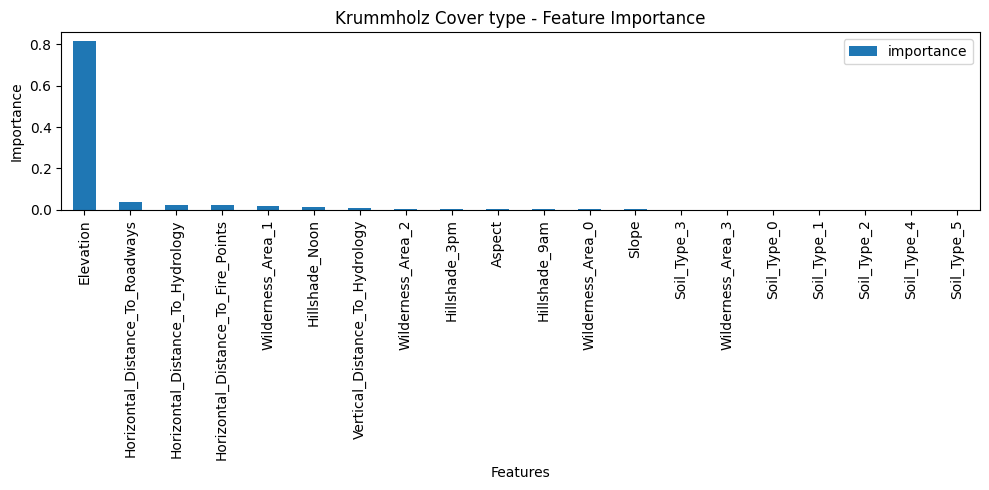

-----------------------------------------------------------------------------------------------




Processing CSV file: CottonwoodWillow.csv
CottonwoodWillow importance list:
CottonwoodWillow 
                                     importance
Features                                      
Elevation                             0.976644
Wilderness_Area_3                     0.009037
Soil_Type_4                           0.002740
Wilderness_Area_2                     0.001848
Hillshade_9am                         0.001358
Horizontal_Distance_To_Hydrology      0.001019
Horizontal_Distance_To_Roadways       0.000908
Vertical_Distance_To_Hydrology        0.000886
Horizontal_Distance_To_Fire_Points    0.000840
Slope                                 0.000577
Aspect                                0.000462
Hillshade_3pm                         0.000438
Soil_Type_5                           0.000221
Hillshade_Noon                        0.000161
Soil_Type_0                           0.000009
Soil_T

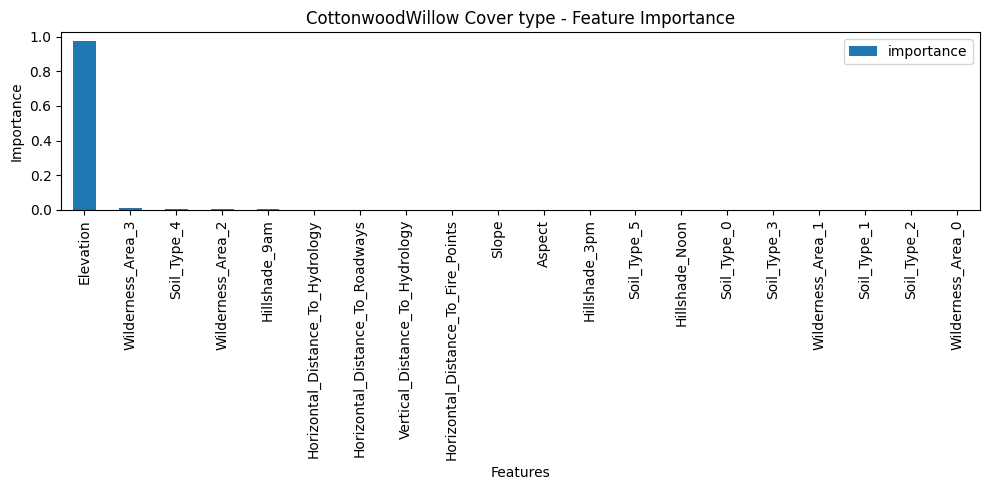

-----------------------------------------------------------------------------------------------




Processing CSV file: DouglasFir.csv
DouglasFir importance list:
DouglasFir 
                                       importance
Features                                        
Elevation                           6.931612e-01
Wilderness_Area_0                   9.223404e-02
Horizontal_Distance_To_Roadways     3.948552e-02
Horizontal_Distance_To_Fire_Points  3.480843e-02
Wilderness_Area_2                   2.302104e-02
Aspect                              2.208499e-02
Vertical_Distance_To_Hydrology      1.607488e-02
Horizontal_Distance_To_Hydrology    9.058927e-03
Hillshade_Noon                      8.925966e-03
Hillshade_9am                       8.307955e-03
Hillshade_3pm                       8.142651e-03
Slope                               4.962515e-03
Soil_Type_2                         3.584502e-03
Wilderness_Area_3                   2.417456e-03
Soil_Type_1                         1.8

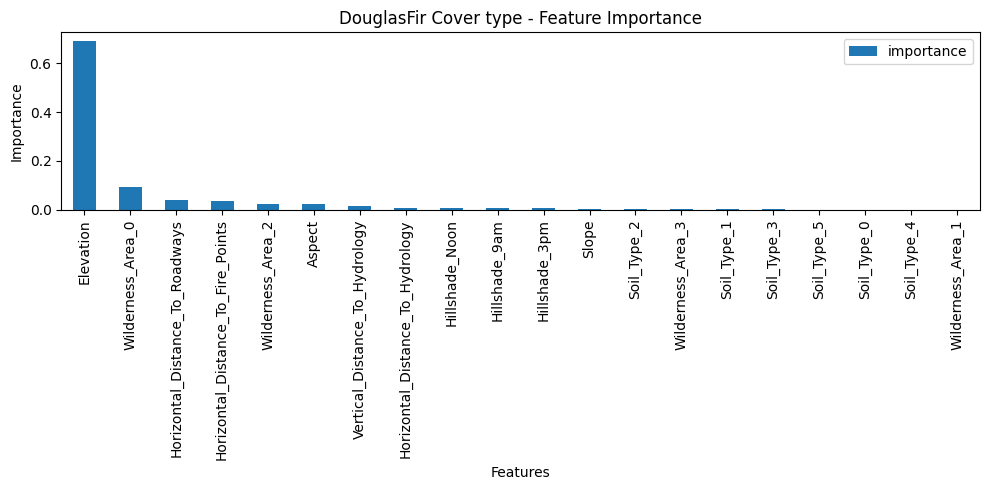

-----------------------------------------------------------------------------------------------




Processing CSV file: Aspen.csv
Aspen importance list:
Aspen 
                                     importance
Features                                      
Elevation                             0.317727
Horizontal_Distance_To_Roadways       0.143774
Horizontal_Distance_To_Fire_Points    0.126071
Hillshade_9am                         0.045884
Horizontal_Distance_To_Hydrology      0.040623
Vertical_Distance_To_Hydrology        0.037971
Hillshade_Noon                        0.035598
Aspect                                0.033679
Hillshade_3pm                         0.024639
Slope                                 0.018977
Soil_Type_1                           0.011589
Soil_Type_3                           0.009794
Wilderness_Area_2                     0.006665
Wilderness_Area_0                     0.004497
Soil_Type_2                           0.000945
Wilderness_Area_3                     0

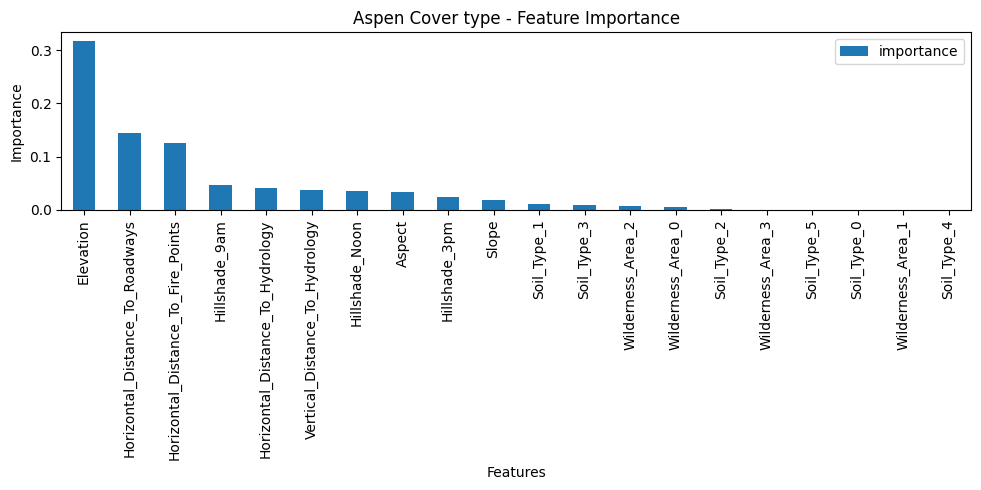

-----------------------------------------------------------------------------------------------




Processing CSV file: Spruce-Fir.csv
Portscan.csv created with 1506 rows. (1004 benign and 502 abnormal rows)
Webattack.csv created with 2058 rows. (1372 benign and 686 abnormal rows)
Infiltration.csv created with 63321 rows. (42214 benign and 21107 abnormal rows)
Bruteforce.csv created with 69867 rows. (46578 benign and 23289 abnormal rows)
Botnet.csv created with 97170 rows. (64780 benign and 32390 abnormal rows)
DoS.csv created with 263829 rows. (175886 benign and 87943 abnormal rows)
DDoS.csv created with 822849 rows. (548566 benign and 274283 abnormal rows)
Spruce-Fir importance list:
Spruce-Fir 
                                       importance
Features                                        
Elevation                           3.278901e-01
Horizontal_Distance_To_Roadways     1.575854e-01
Horizontal_Distance_To_Fire_Points  1.574437e-01
Horizontal_Distance_To_Hydrology    6.798816e-

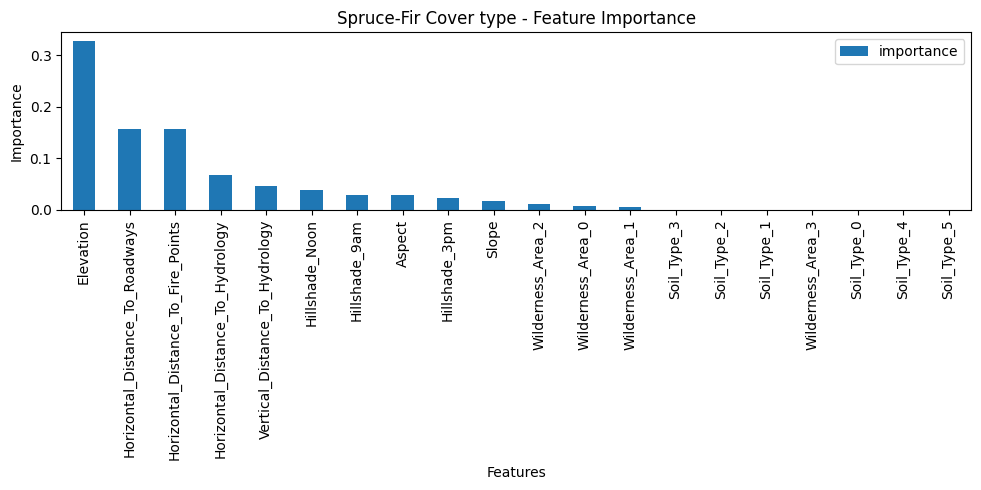

-----------------------------------------------------------------------------------------------




Processing CSV file: PonderosaPine.csv
PonderosaPine importance list:
PonderosaPine 
                                     importance
Features                                      
Elevation                             0.688264
Wilderness_Area_0                     0.091824
Soil_Type_3                           0.045740
Soil_Type_1                           0.044210
Horizontal_Distance_To_Roadways       0.031859
Horizontal_Distance_To_Fire_Points    0.023706
Horizontal_Distance_To_Hydrology      0.011573
Vertical_Distance_To_Hydrology        0.008736
Hillshade_Noon                        0.007512
Hillshade_9am                         0.007092
Aspect                                0.006468
Hillshade_3pm                         0.004395
Slope                                 0.003746
Soil_Type_2                           0.001437
Wilderness_Area_2                     0.001358
Wilderness_Area

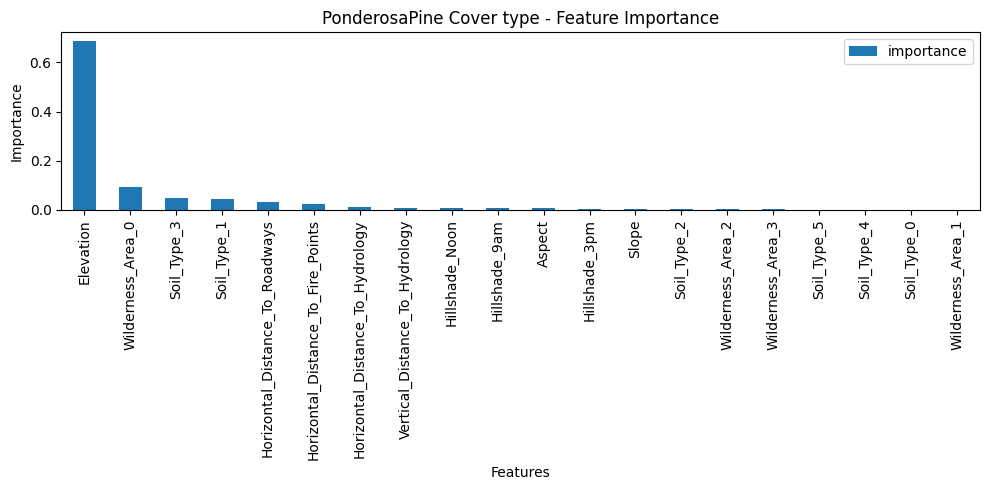

-----------------------------------------------------------------------------------------------




feature_importances: {'Krummholz': ['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Hydrology', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_1'], 'CottonwoodWillow': ['Elevation', 'Wilderness_Area_3', 'Soil_Type_4', 'Wilderness_Area_2', 'Hillshade_9am'], 'DouglasFir': ['Elevation', 'Wilderness_Area_0', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_2'], 'Aspen': ['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Hillshade_9am', 'Horizontal_Distance_To_Hydrology'], 'Spruce-Fir': ['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology'], 'PonderosaPine': ['Elevation', 'Wilderness_Area_0', 'Soil_Type_3', 'Soil_Type_1', 'Horizontal_Distance_To_Roadways']}
Total operation time: = 328

In [361]:
seconds = time.time()

# CSV files names:
csv_files = os.listdir(OUTPUT_FOLDER)
print('csv_files',csv_files)

feature_importances = {}
SVMs = {}

# Linear way
for csv in csv_files:
    label, important_features, svm, impor_bars, voting_clf = process_csv_with_args(csv, 
        main_labels=main_labels, 
        target_column=TARGET_COLUMN, 
        normal_target=NORMAL_TARGET, 
        numerical_columns=NUMERICAL_COLUMNS, 
        output_folder=OUTPUT_FOLDER,
        scaler=scaler)
    feature_importances[label] = important_features
    SVMs[label] = svm
    common.show_feature_importance(impor_bars, label, FEATURE_FOLDER)
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

# Function to process a CSV file and return relevant outputs
# def process_csv_file(csv_file):
#     return process_csv_with_args(
#         csv_file,
#         main_labels=main_labels,
#         target_column=TARGET_COLUMN,
#         normal_target=NORMAL_TARGET,
#         numerical_columns=NUMERICAL_COLUMNS,
#         output_folder=OUTPUT_FOLDER,
#         scaler=scaler
#     )

# # Use Joblib to parallelize the processing of CSV files
# results = Parallel(n_jobs=-1)(
#     delayed(process_csv_file)(csv) for csv in csv_files
# )

# # Process the results to extract feature importances and SVMs
# for label, important_features, svm, impor_bars, voting_clf in results:
#     feature_importances[label] = important_features
#     SVMs[label] = svm
    
#     # Show feature importance
#     common.show_feature_importance(impor_bars, label, FEATURE_FOLDER)
#     print("-----------------------------------------------------------------------------------------------\n\n\n\n")

print('feature_importances:', feature_importances)
print("Total operation time: =", time.time() - seconds, "seconds")

In [259]:
seconds = time.time()

# Step 1: Train KNN to classify
knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_train_scaled_df, y_train_df)
knn.fit(X_train_df, y_train_df)

# Step 2: Predict classes for the test set
print('Cap testset with length ', len(X_test_df),' at ',TEST_COUNT)
X_test_backup_df = X_test_df.copy()
X_test_scaled_backup_df = X_test_scaled_df.copy()
X_test_df = X_test_df[:TEST_COUNT]
X_test_scaled_df = X_test_scaled_df[:TEST_COUNT]
y_test_df = y_test_df[:TEST_COUNT]

# knn_predictions = knn.predict(X_test_scaled_df)
knn_predictions = knn.predict(X_test_df)
print('knn_predictions', knn_predictions)

print("Total operation time: = ",time.time()- seconds ,"seconds")

Cap testset with length  1331  at  15000
knn_predictions [0 0 0 ... 0 0 0]
Total operation time: =  0.035176992416381836 seconds


-----KNN Evaluation-----


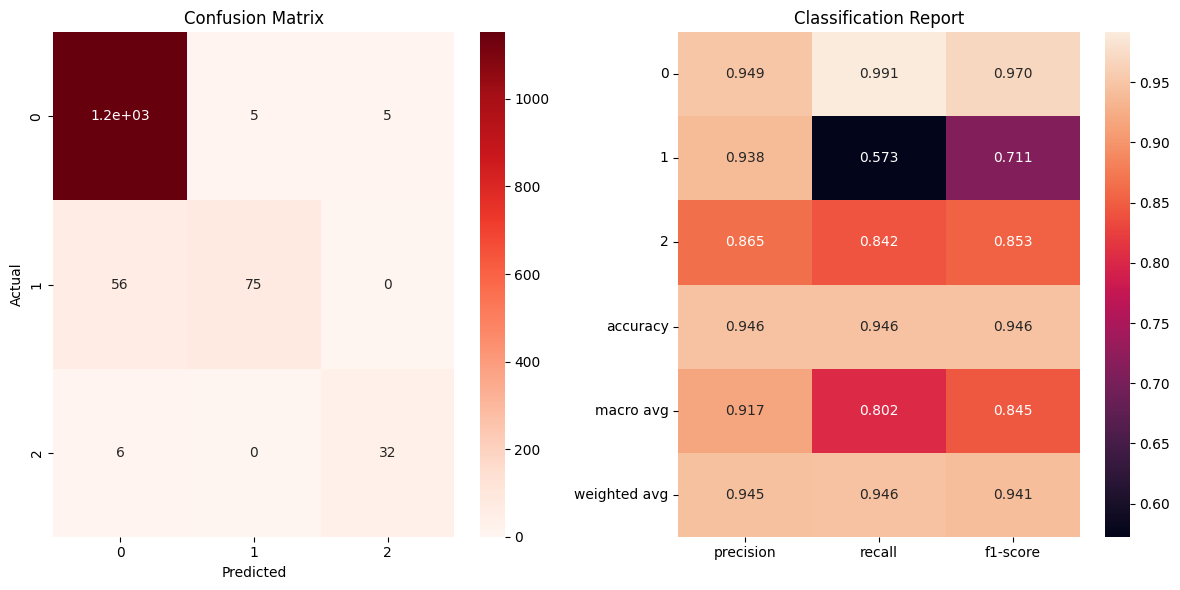

Accuracy: 0.9459053343350864


(array([[1152,    5,    5],
        [  56,   75,    0],
        [   6,    0,   32]]),
 {'0': {'precision': 0.9489291598023064,
   'recall': 0.9913941480206541,
   'f1-score': 0.9696969696969697,
   'support': 1162.0},
  '1': {'precision': 0.9375,
   'recall': 0.5725190839694656,
   'f1-score': 0.7109004739336493,
   'support': 131.0},
  '2': {'precision': 0.8648648648648649,
   'recall': 0.8421052631578947,
   'f1-score': 0.8533333333333334,
   'support': 38.0},
  'accuracy': 0.9459053343350864,
  'macro avg': {'precision': 0.9170980082223904,
   'recall': 0.8020061650493382,
   'f1-score': 0.8446435923213175,
   'support': 1331.0},
  'weighted avg': {'precision': 0.9454042438430841,
   'recall': 0.9459053343350864,
   'f1-score': 0.9409034617128877,
   'support': 1331.0}},
 0.9459053343350864)

In [262]:
common.evaluate(y_test_df, knn_predictions, heading='-----KNN Evaluation-----', target_dict=config['TARGET_DICT'])

In [263]:
svm_predictions = []
seconds = time.time()

for i in range(len(X_test_scaled_df)):
    test_instance_df = X_test_scaled_df.iloc[i].to_frame().T
    if knn_predictions[i] == NORMAL_TARGET:
        svm_predictions.append((0, NORMAL_TARGET, y_test_df.iloc[i]))
        continue
    predicted_label = TARGET_DICT[knn_predictions[i]]
    # print('predicted_label', predicted_label)
    selected_features = feature_importances[predicted_label]
    # print('selected_features', selected_features)
    svm_model = SVMs[predicted_label]
    
    # Select features for the SVM
    test_instance_selected_df = test_instance_df[selected_features]
    svm_prediction = svm_model.predict(test_instance_selected_df)
    print('svm prediction: ', svm_prediction, 'knn prediction: ', INV_TARGET_DICT[predicted_label], 'actual value: ', y_test_df.iloc[i])
    svm_predictions.append((svm_prediction, INV_TARGET_DICT[predicted_label], y_test_df.iloc[i]))

print("Total operation time: = ",time.time()- seconds ,"seconds")

svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  0
svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [0] knn prediction:  1 actual value:  0
svm prediction:  [0] knn prediction:  2 actual value:  2
svm prediction:  [0] knn predic

-----SVM Evaluation (for anomalies)-----


/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

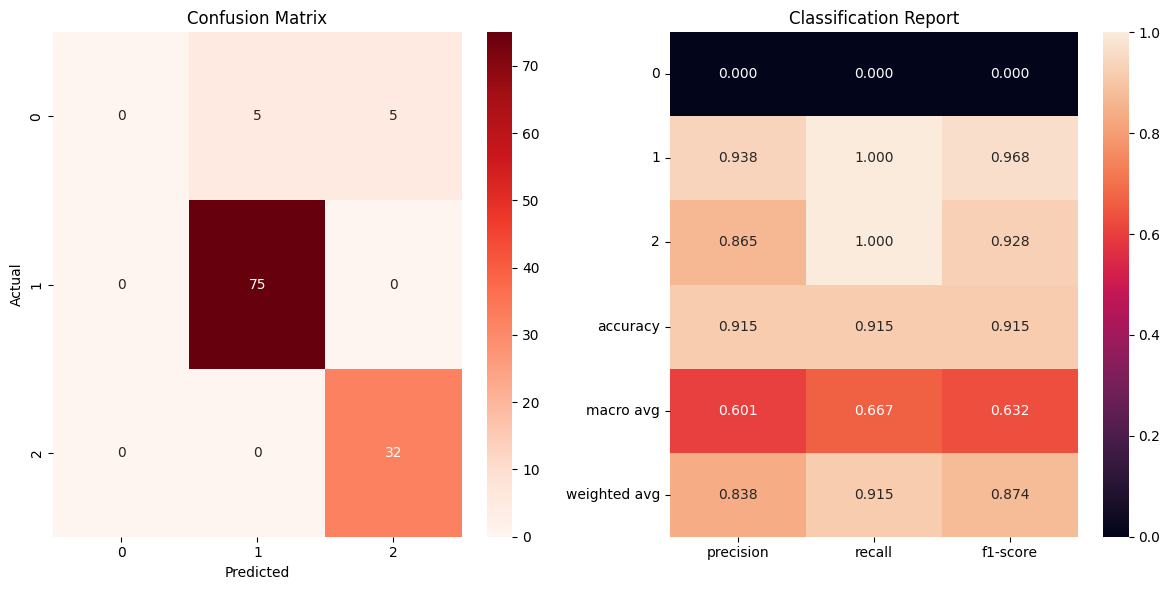

Accuracy: 0.9145299145299145


(array([[ 0,  5,  5],
        [ 0, 75,  0],
        [ 0,  0, 32]]),
 {'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0},
  '1': {'precision': 0.9375,
   'recall': 1.0,
   'f1-score': 0.967741935483871,
   'support': 75.0},
  '2': {'precision': 0.8648648648648649,
   'recall': 1.0,
   'f1-score': 0.927536231884058,
   'support': 32.0},
  'accuracy': 0.9145299145299145,
  'macro avg': {'precision': 0.6007882882882883,
   'recall': 0.6666666666666666,
   'f1-score': 0.6317593891226431,
   'support': 117.0},
  'weighted avg': {'precision': 0.837505775005775,
   'recall': 0.9145299145299145,
   'f1-score': 0.8740325177912835,
   'support': 117.0}},
 0.9145299145299145)

In [264]:
# Now evaluate SVM predictions only for the anomalies detected by KNN
# Create a mask for test instances that KNN classified as anomalies
anomaly_mask = knn_predictions != NORMAL_TARGET  # Assuming normal_target is your normal class
# print('anomaly_mask', len(anomaly_mask))

# Get true labels and predictions for anomalies
svm_predictions_actual = [knn if pred == 0 else NORMAL_TARGET for pred, knn, y_test in svm_predictions]
# print(svm_predictions_actual)
svm_predictions_actual_df = pd.DataFrame(svm_predictions_actual, columns=[TARGET_COLUMN])
y_test_anomalies_df = y_test_df[anomaly_mask]
svm_predictions_anomalies_df = svm_predictions_actual_df[anomaly_mask]
# print('Lengths: ', len(y_test_anomalies_df), len(svm_predictions_anomalies_df))

# Evaluate SVM only on the anomalies
common.evaluate(y_test_anomalies_df, svm_predictions_anomalies_df, heading='-----SVM Evaluation (for anomalies)-----', target_dict=config['TARGET_DICT'])

SVM Evaluation (for all)


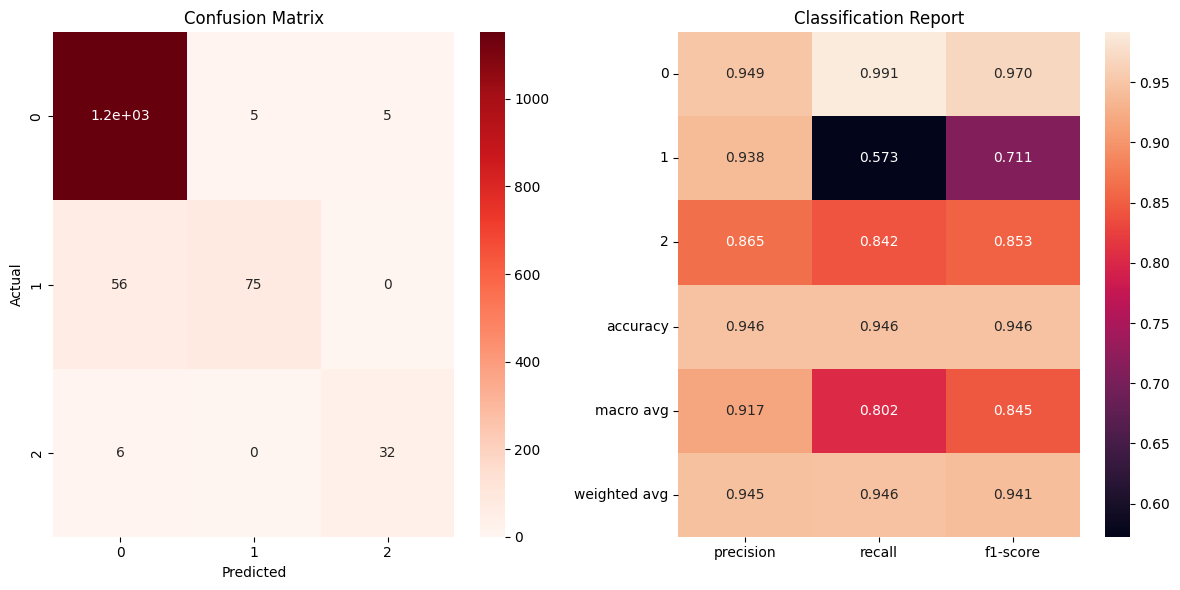

Accuracy: 0.9459053343350864


(array([[1152,    5,    5],
        [  56,   75,    0],
        [   6,    0,   32]]),
 {'0': {'precision': 0.9489291598023064,
   'recall': 0.9913941480206541,
   'f1-score': 0.9696969696969697,
   'support': 1162.0},
  '1': {'precision': 0.9375,
   'recall': 0.5725190839694656,
   'f1-score': 0.7109004739336493,
   'support': 131.0},
  '2': {'precision': 0.8648648648648649,
   'recall': 0.8421052631578947,
   'f1-score': 0.8533333333333334,
   'support': 38.0},
  'accuracy': 0.9459053343350864,
  'macro avg': {'precision': 0.9170980082223904,
   'recall': 0.8020061650493382,
   'f1-score': 0.8446435923213175,
   'support': 1331.0},
  'weighted avg': {'precision': 0.9454042438430841,
   'recall': 0.9459053343350864,
   'f1-score': 0.9409034617128877,
   'support': 1331.0}},
 0.9459053343350864)

In [265]:
common.evaluate(y_test_df, svm_predictions_actual_df, heading='SVM Evaluation (for all)', target_dict=config['TARGET_DICT'])